# Hate Speech Detection using Deep Learning (LSTM)

**Course:** CSE485 – Deep Learning  
**Dataset:** Hate Speech Tweets Dataset  


In [4]:
# OPTIONAL (run once only if dataset is not available locally)
# This cell downloads the dataset from the source and saves it locally

# import pandas as pd
# url = "https://media.geeksforgeeks.org/wp-content/uploads/20250321123144355200/Dataset---Hate-Speech-Detection-using-Deep-Learning.csv"
# df = pd.read_csv(url)
# df.to_csv("../data/hate_speech.csv", index=False)


## Environment Setup
This notebook requires the libraries listed in `requirements.txt`.
Additionally, the following NLTK resources must be downloaded:
- stopwords
- wordnet
- omw-1.4

In [53]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Deep Learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional


# HTML display
import html

#Saving and loading models
import os
import pickle
from tensorflow.keras.models import load_model


## Step 1 Database Visualizations

### Loading data and counting

In [6]:
df = pd.read_csv("../data/hate_speech.csv")
df.head()


,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
df.shape

(24783, 2)

In [8]:
df['class'].value_counts()


class
1    19190
2     4163
0     1430
Name: count, dtype: int64

### Visualizations

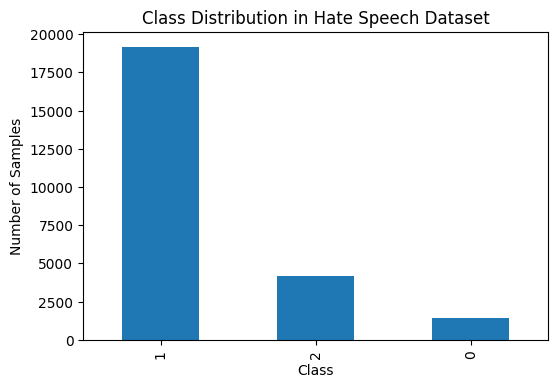

In [9]:
plt.figure(figsize=(6,4))
df['class'].value_counts().plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Hate Speech Dataset")
plt.show()


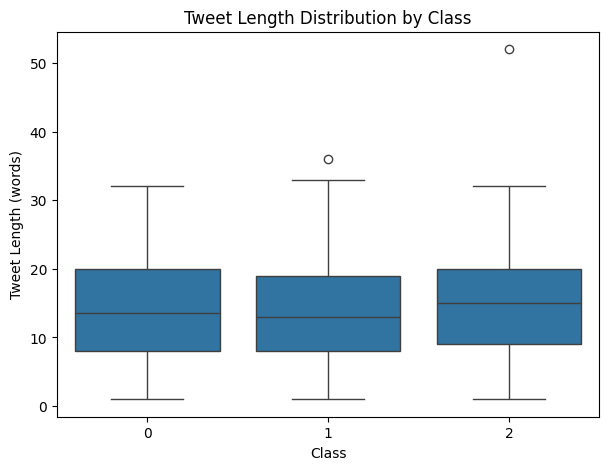

In [10]:
df['tweet_length'] = df['tweet'].apply(lambda x: len(x.split()))

plt.figure(figsize=(7,5))
sns.boxplot(x='class', y='tweet_length', data=df)
plt.xlabel("Class")
plt.ylabel("Tweet Length (words)")
plt.title("Tweet Length Distribution by Class")
plt.show()


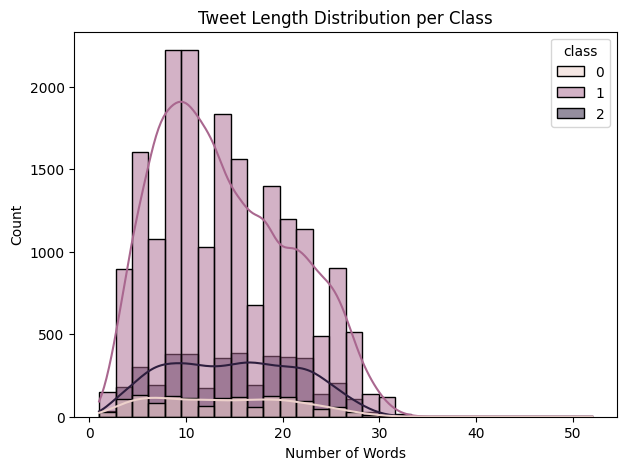

In [11]:
plt.figure(figsize=(7,5))
sns.histplot(data=df, x='tweet_length', hue='class', bins=30, kde=True)
plt.title("Tweet Length Distribution per Class")
plt.xlabel("Number of Words")
plt.show()


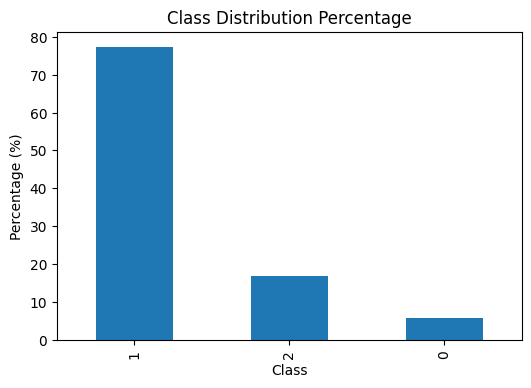

In [12]:
class_percent = df['class'].value_counts(normalize=True) * 100

plt.figure(figsize=(6,4))
class_percent.plot(kind='bar')
plt.ylabel("Percentage (%)")
plt.xlabel("Class")
plt.title("Class Distribution Percentage")
plt.show()


### Class weights to balance the dataset

In [13]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['class']),
    y=df['class']
)

class_weights = dict(zip(np.unique(df['class']), class_weights))
class_weights


{0: 5.776923076923077, 1: 0.43048462741010945, 2: 1.9843862599087196}

## Step 2 Text Preprocessing

### Text Cleaning

In [14]:
def clean_text(text):
    text = html.unescape(text)                       # decode HTML entities (&amp; -> &)
    text = text.lower()
    text = re.sub(r'\brt\b', '', text)               # remove RT
    text = re.sub(r'http\S+|www\S+', '', text)       # remove URLs
    text = re.sub(r'@\w+', '', text)                 # remove mentions
    text = re.sub(r'#', '', text)                    # remove hashtag symbol
    text = re.sub(r'[^a-z\s]', '', text)             # remove punctuation & numbers
    text = re.sub(r'\s+', ' ', text).strip()         # remove extra spaces
    return text


In [15]:

df['clean_tweet'] = df['tweet'].apply(clean_text)


### Stopwords Removal + Lemmatization

In [16]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = text.split()
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words
    ]
    return ' '.join(tokens)


In [17]:
df['processed_tweet'] = df['clean_tweet'].apply(preprocess_text)


### Verifying Cleaning is good enough

#### Comparing between tweet, After cleaning, After processing

In [18]:
# Random samples
df[['tweet', 'clean_tweet', 'processed_tweet']].sample(10, random_state=42)


,tweet,clean_tweet,processed_tweet
2281,934 8616\ni got a missed call from yo bitch,i got a missed call from yo bitch,got missed call yo bitch
15914,RT @KINGTUNCHI_: Fucking with a bad bitch you ...,fucking with a bad bitch you gone need some mo...,fucking bad bitch gone need money lil homie
18943,RT @eanahS__: @1inkkofrosess lol my credit ain...,lol my credit aint no where near good but i kn...,lol credit aint near good know right man job h...
16407,RT @Maxin_Betha Wipe the cum out of them faggo...,wipe the cum out of them faggot contact lens i...,wipe cum faggot contact lens wildin cant see shit
13326,Niggas cheat on they bitch and don't expect no...,niggas cheat on they bitch and dont expect no ...,nigga cheat bitch dont expect pay back whatsoe...
12914,Mother asked what I wanted for Christmas this ...,mother asked what i wanted for christmas this ...,mother asked wanted christmas year replied go ...
21457,That's real dedication. .. &#171;@arigold_88 T...,thats real dedication this bitch got diarrhea ...,thats real dedication bitch got diarrhea still...
12246,"Kiss IMO this conductor, it's 4:30 AM have som...",kiss imo this conductor its am have some court...,kiss imo conductor courtesy bitch
13083,My momma keep talking to me like bitch gtf I'm...,my momma keep talking to me like bitch gtf im ...,momma keep talking like bitch gtf im twitter
19409,RT @karlos_budah: I kno this bitch a thot she ...,i kno this bitch a thot she wanna meet my momm...,kno bitch thot wanna meet momma


#### Checking most common words to make sure we removed unnecessary data

In [19]:
from collections import Counter

all_words = ' '.join(df['processed_tweet']).split()
Counter(all_words).most_common(30)


[('bitch', 11332),
 ('hoe', 4279),
 ('like', 2819),
 ('pussy', 2227),
 ('im', 2090),
 ('nigga', 1991),
 ('dont', 1781),
 ('as', 1571),
 ('get', 1537),
 ('u', 1463),
 ('fuck', 1448),
 ('got', 1290),
 ('shit', 1281),
 ('aint', 1169),
 ('trash', 1151),
 ('lol', 1070),
 ('know', 855),
 ('one', 751),
 ('love', 738),
 ('girl', 695),
 ('go', 694),
 ('cant', 670),
 ('want', 660),
 ('yall', 660),
 ('fucking', 630),
 ('thats', 625),
 ('yo', 616),
 ('make', 596),
 ('bird', 588),
 ('look', 582)]

#### Length Distribution AFTER Cleaning

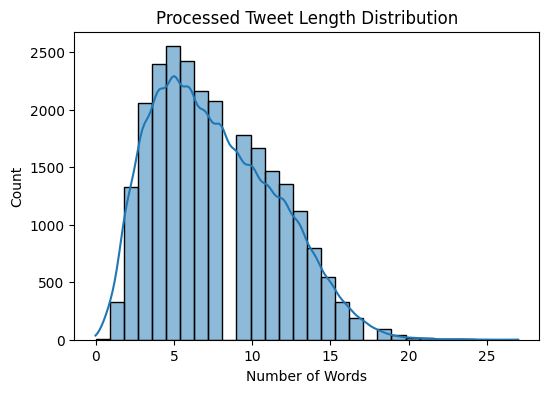

In [20]:
df['processed_length'] = df['processed_tweet'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.histplot(df['processed_length'], bins=30, kde=True)
plt.title("Processed Tweet Length Distribution")
plt.xlabel("Number of Words")
plt.show()


### Tokenization & Padding

In [21]:
MAX_WORDS = 10000   # vocabulary size
MAX_LEN = 20        # max sequence length

tokenizer = Tokenizer(
    num_words=MAX_WORDS,
    oov_token="<OOV>"
)


In [22]:
tokenizer.fit_on_texts(df['processed_tweet'])
sequences = tokenizer.texts_to_sequences(df['processed_tweet'])
print(df['processed_tweet'].iloc[0])
print(sequences[0])


woman shouldnt complain cleaning house man always take trash
[98, 845, 936, 2993, 203, 35, 83, 67, 16]


In [23]:
X = pad_sequences(
    sequences,
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)
y = df['class'].values

print(X.shape)

(24783, 20)


## Step 3 Dataset Splitting

### Train 70%, test and val 15%

In [24]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)


### Verifying shapes and distribution

In [25]:
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (17348, 20)
Validation: (3717, 20)
Test: (3718, 20)


In [26]:
def class_distribution(y, name):
    print(f"\n{name} distribution:")
    print(pd.Series(y).value_counts(normalize=True))

class_distribution(y_train, "Train")
class_distribution(y_val, "Validation")
class_distribution(y_test, "Test")



Train distribution:
1    0.774326
2    0.167973
0    0.057701
Name: proportion, dtype: float64

Validation distribution:
1    0.774280
2    0.167877
0    0.057842
Name: proportion, dtype: float64

Test distribution:
1    0.774341
2    0.168101
0    0.057558
Name: proportion, dtype: float64


## Step 4 Model Architecture

### Build Model


In [36]:
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128),
    LSTM(96),
    Dropout(0.6),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])


### Compile And Summary

In [37]:
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Step 5 Model Training 

In [38]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)



In [39]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping]
)


Epoch 1/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.4346 - loss: 1.0739 - val_accuracy: 0.8025 - val_loss: 0.6430
Epoch 2/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7840 - loss: 0.5596 - val_accuracy: 0.8012 - val_loss: 0.5376
Epoch 3/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8472 - loss: 0.3405 - val_accuracy: 0.7848 - val_loss: 0.5298
Epoch 4/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.8692 - loss: 0.2878 - val_accuracy: 0.7869 - val_loss: 0.6077
Epoch 5/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9013 - loss: 0.2201 - val_accuracy: 0.7867 - val_loss: 0.6458
Epoch 6/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9145 - loss: 0.1796 - val_accuracy: 0.8582 - val_loss: 0.4784
Epoch 7/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9252 - loss: 0.1691 - val_accuracy: 0.8275 - val_loss: 0.5615
Epoch 8/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9342 - loss: 0.1373 - 

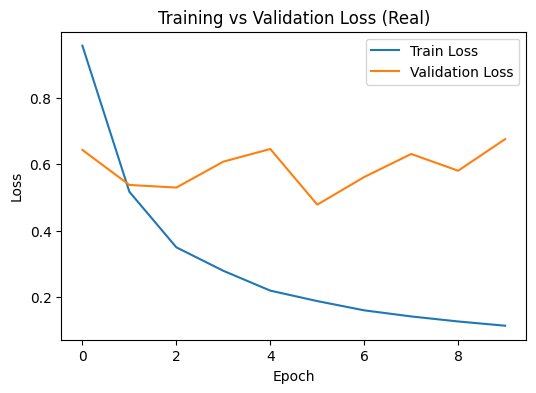

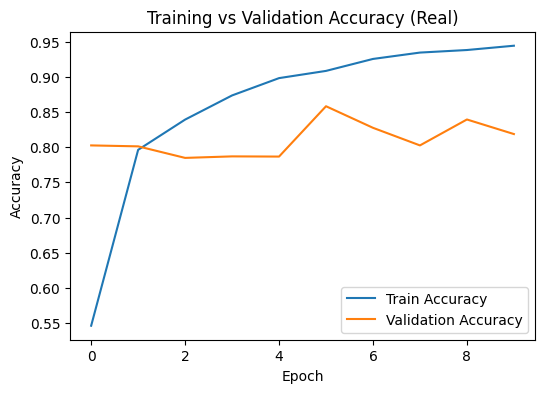

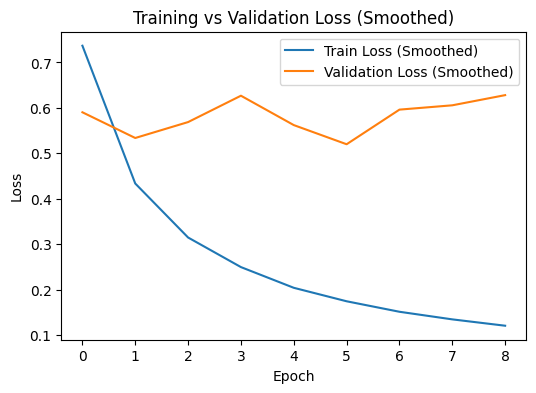

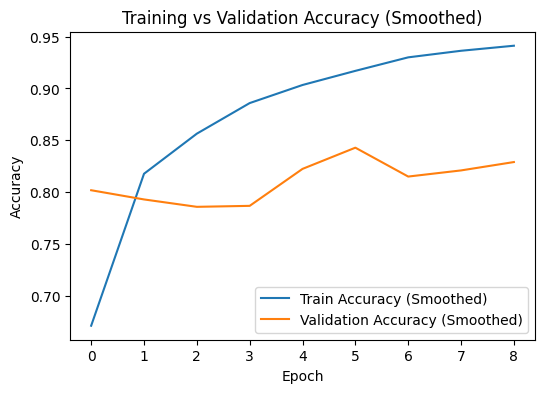

In [52]:
epochs = range(len(history.history['loss']))

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Light smoothing (moving average)
def smooth_curve(values, window=2):
    return np.convolve(values, np.ones(window)/window, mode='valid')

smooth_train_loss = smooth_curve(train_loss)
smooth_val_loss = smooth_curve(val_loss)
smooth_train_acc = smooth_curve(train_acc)
smooth_val_acc = smooth_curve(val_acc)

# =========================
# 1️⃣ REAL LOSS
# =========================
plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training vs Validation Loss (Real)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# =========================
# 2️⃣ REAL ACCURACY
# =========================
plt.figure(figsize=(6,4))
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title("Training vs Validation Accuracy (Real)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# =========================
# 3️⃣ SMOOTHED LOSS
# =========================
plt.figure(figsize=(6,4))
plt.plot(range(len(smooth_train_loss)), smooth_train_loss, label="Train Loss (Smoothed)")
plt.plot(range(len(smooth_val_loss)), smooth_val_loss, label="Validation Loss (Smoothed)")
plt.title("Training vs Validation Loss (Smoothed)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# =========================
# 4️⃣ SMOOTHED ACCURACY
# =========================
plt.figure(figsize=(6,4))
plt.plot(range(len(smooth_train_acc)), smooth_train_acc, label="Train Accuracy (Smoothed)")
plt.plot(range(len(smooth_val_acc)), smooth_val_acc, label="Validation Accuracy (Smoothed)")
plt.title("Training vs Validation Accuracy (Smoothed)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## Step 6 Model Evaluation (Test Set)

In [41]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8484 - loss: 0.5023
Test Accuracy: 0.8607
Test Loss: 0.4644


In [42]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [43]:
print(classification_report(
    y_test,
    y_pred,
    target_names=['Hate Speech', 'Offensive Language', 'Neither']
))

                    precision    recall  f1-score   support

       Hate Speech       0.32      0.47      0.38       214
Offensive Language       0.95      0.88      0.91      2879
           Neither       0.77      0.89      0.83       625

          accuracy                           0.86      3718
         macro avg       0.68      0.75      0.71      3718
      weighted avg       0.88      0.86      0.87      3718



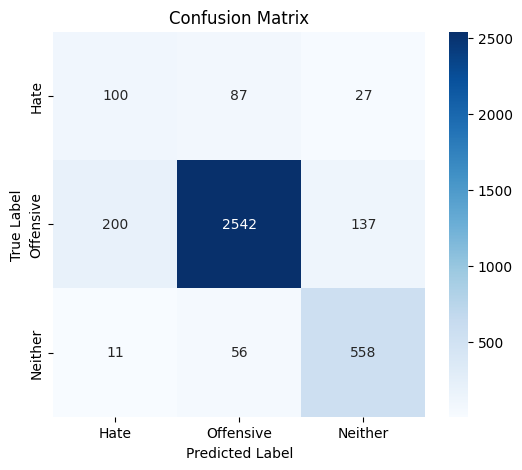

In [44]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Hate', 'Offensive', 'Neither'],
    yticklabels=['Hate', 'Offensive', 'Neither']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Extra Step: Saving Model Data

In [54]:
os.makedirs("../models", exist_ok=True)

# Save model (recommended format)
model.save("../models/hate_speech_lstm.keras")

# Save tokenizer
with open("../models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save history if exists
if "history" in globals():
    with open("../models/history.pkl", "wb") as f:
        pickle.dump(history.history, f)

print("Model, tokenizer, and history saved successfully ✅")


Model, tokenizer, and history saved successfully ✅
